# Import

In [1]:
from abc import ABC,abstractmethod
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from numba import jit
import numpy as np

# Helper functions

In [2]:
class OptimisationTarget(Enum):
  VIDEO_SUMMERIZATION=1

# Optimization Targets

In [3]:
class Wrapper(object):

    def __init__(self):
      """
      Initialize the Wrapper.

      Initializes the counter to 0.
      """
      self.counter = 0

    def get_ground_set(self, instance=None):
      """
      Get the ground set for the MAX-CUT problem.

      Args:
          instance (numpy.ndarray): The problem instance represented as an array.

      Returns:
          set: The ground set containing the indices of elements in the problem instance.
      """

      self.instance=instance
      return set(np.arange(instance.shape[0]))
    def reset(self):
      """
      Reset the counter to 0.

      This function is used to reset the query counter for the MAX-CUT objective function.
      """
      self.counter = 0



class VIDEO_SUMMERIZATION_Wrapper(Wrapper):
    def objective_value(self, instance=None, sol=None):
      self.counter+=1
      S=list(sol)
      XS = instance[np.ix_(S, S)]
      # I = np.eye(XS.shape[0])
      return np.log(np.linalg.det(XS)+1)

      # return np.linalg.det(I + XS)


# Solver

In [4]:
class Solver(object):
    """
    Abstract base class for algorithms solving problems.

    Attributes:
    optimisation_target (OptimisationTarget): The target optimization problem type.
    wrapper : An instance of the Wrapper for handling the specific problem.
    """

    def __init__(self, optimisation_target=OptimisationTarget.VIDEO_SUMMERIZATION):
        """
        Initialize the Solver.

        Args:
            optimisation_target (OptimisationTarget): The target optimization problem type.
        """
        self.optimisation_target = optimisation_target


        if self.optimisation_target==OptimisationTarget.VIDEO_SUMMERIZATION:
            self.wrapper=VIDEO_SUMMERIZATION_Wrapper()
        else:
            raise NotImplementedError


    def element_add_objective_value(self,instance,curr_sol,element):

        temp_sol=deepcopy(curr_sol)
        temp_sol.add(element)
        return self.wrapper.objective_value(instance, temp_sol)

    def element_remove_objective_value(self,instance,curr_sol,element):

        temp_sol=deepcopy(curr_sol)
        temp_sol.remove(element)
        return self.wrapper.objective_value(instance, temp_sol)

    def get_best_element_add(self,instance=None,curr_sol=None,elements=None):
        current_gain = self.wrapper.objective_value(instance, curr_sol)

        best_marginal_gain_add = -float("inf")
        element_to_add = None

        for element in elements:
            gain_add = self.element_add_objective_value(instance,curr_sol,element) - current_gain
            if gain_add > best_marginal_gain_add:

                best_marginal_gain_add = gain_add
                element_to_add = element

        return element_to_add,best_marginal_gain_add

    def get_best_element_remove(self,instance=None,curr_sol=None):
        current_gain = self.wrapper.objective_value(instance, curr_sol)
        minimum_marginal_gain_remove = float("inf")
        element_to_remove = None
        for element in curr_sol:
            gain_remove = current_gain - self.element_remove_objective_value(instance,curr_sol,element)

            if gain_remove < minimum_marginal_gain_remove:
                minimum_marginal_gain_remove = gain_remove
                element_to_remove = element


        return element_to_remove,minimum_marginal_gain_remove

In [5]:
class Standard_Greedy(Solver):

    def solve(self,instance,size_constraint,**kwargs):

        ground_set = self.wrapper.get_ground_set(instance)
        curr_sol=set([])

        self.wrapper.reset()
        for step in range(size_constraint):
            element_to_add,best_marginal_gain_add=self.get_best_element_add(instance,curr_sol,ground_set - curr_sol)
            # print(element_to_add,best_marginal_gain_add)
            if best_marginal_gain_add<=0:
#                 print("Standard Greedy stops at:",step)
                break
            else:
                curr_sol.add(element_to_add)


        result =  self.wrapper.objective_value(instance,curr_sol)
        queries = self.wrapper.counter

        self.wrapper.reset()

        return result,queries,curr_sol

In [6]:
class Random_Greedy(Solver):
    def solve(self,instance,size_constraint,**kwargs):

        # Get the ground set and initialize the current solution
        ground_set = self.wrapper.get_ground_set(instance)
        curr_sol = set()

        # Reset the wrapper
        self.wrapper.reset()
        for i in range(1, size_constraint+ 1):

            gains = []

            # Calculate the current gain of the solution
            current_gain = self.wrapper.objective_value(instance, curr_sol)

            for element in ground_set - curr_sol:

                temp_sol = deepcopy(curr_sol)
                temp_sol.add(element)

                # Calculate the gain from adding the element to the solution
                gain = self.wrapper.objective_value(instance, temp_sol) - current_gain

                gains.append((gain, element))

            gains = sorted(gains, key=lambda x: x[0], reverse=True)

            

            # Select the top k elements
            M = gains[:size_constraint]
            elements=[element[1] for element in M if element[0]>0]
            # Randomly choose an element to add to the current solution
            if len(elements)>0:
                element_to_add = np.random.choice(elements)
            else:
                break

            curr_sol.add(element_to_add)


        # Calculate the result and the number of queries made to the objective function
        result =  self.wrapper.objective_value(instance,curr_sol)
        queries = self.wrapper.counter

        # Reset the wrapper for future use
        self.wrapper.reset()

        return result,queries,curr_sol

In [7]:
class FLS_RAND_GREEDY(Solver):
    """
    FLS_RAND_GREEDY is a solver for local search optimization problems using guided random greedy techniques.

    Attributes:
    optimisation_target (OptimisationTarget): The target optimization problem type.

    """


    def approximation_result(self,instance=None,ground_set=None):


        element,_=self.get_best_element_add(instance=instance,curr_sol=set(),elements=ground_set)

        return set([element])

    def solve(self, instance, size_constraint, error_rate):
        """
        Perform local search optimization on the given instance using a guided random greedy algorithm.

        Args:
            instance (numpy.ndarray): The optimization problem instance represented as an array.
            size_constraint (int): The size constraint for the termination condition.
            error_rate (float): The error rate parameter for the termination condition.

        Returns:
            tuple: A tuple containing the optimized solution and the number of queries made to the objective function.
        """

        # Initialize the ground set, current solution, and other variables
        ground_set = self.wrapper.get_ground_set(instance=instance)
        # print(f"Number of elements in the ground set={len(ground_set)}")
        curr_sol = self.approximation_result(instance=instance,ground_set=ground_set)
        # print("The approximation result",curr_sol)

        # Fast local search Phase
        t = 0.372

        self.wrapper.reset()

        continue_search=True
        while continue_search:
#             print(curr_sol)
            



            continue_search=False

            a=None
            e=None

            max_e=-10000
            max_a=-10000
            

            current_objective_value=self.wrapper.objective_value(instance,curr_sol)

            for element in ground_set:
                temp_sol=deepcopy(curr_sol)
                if element in curr_sol:
                   temp_sol.remove(element)
                   _temp=self.wrapper.objective_value(instance,temp_sol)-current_objective_value
                #    _temp=self.wrapper.objective_value(instance,temp_sol)
                   if _temp>max_e:
                      max_e=_temp
                      e= element
                   
                else:
                   temp_sol.add(element)
                   _temp=self.wrapper.objective_value(instance,temp_sol)-current_objective_value
                   if _temp>max_a:
                      max_a=_temp
                      a = element

            
            if len(curr_sol)<size_constraint and max_a>=(error_rate/size_constraint)*current_objective_value:
                continue_search=True
                curr_sol.add(a)
            
            elif max_a+max_e>=(error_rate/size_constraint)*current_objective_value:
                continue_search=True
                curr_sol.add(a)
                curr_sol.remove(e)
            

            elif max_e>= (error_rate/size_constraint)*current_objective_value:
                continue_search=True
                curr_sol.remove(e)




                   




            # e_set=ground_set-curr_sol
            # # e_set.add(None)

            # if len(curr_sol)==size_constraint:
            #     a_set=deepcopy(curr_sol)

            # elif len(curr_sol)<size_constraint:
            #     a_set=deepcopy(curr_sol)
            #     # a_set.add(None)

            

            # for e in e_set:
            #     for a in a_set:

            #         temp_sol=deepcopy(curr_sol)
            #         if e is not None:
            #             temp_sol.add(e)
            #         if a is not None:
            #             temp_sol.remove(a)

            #         new_objective_value=self.wrapper.objective_value(instance,temp_sol)

            #         if new_objective_value-current_objective_value>=(error_rate / size_constraint) * current_objective_value:

            #             if e is not None:
            #                 curr_sol.add(e)
            #             if a is not None:
            #                 curr_sol.remove(a)
            #             continue_search=True
            #             break

                if continue_search:
                    break




        # Guided Random Greedy

        Z = deepcopy(curr_sol)  # guidance set
        # print(Z)


        curr_sol = set()
        for i in range(1, size_constraint+ 1):

            gains = []

            current_gain = self.wrapper.objective_value(instance, curr_sol)
            if i <= t * size_constraint:

                temp_set = ground_set - curr_sol - Z
            else:
                temp_set = ground_set - curr_sol

            for element in temp_set:

                temp_sol = deepcopy(curr_sol)
                temp_sol.add(element)

                gain = self.wrapper.objective_value(instance, temp_sol) - current_gain

                gains.append((gain, element))

            gains = sorted(gains, key=lambda x: x[0], reverse=True)

            # select the top k elements

            # UPDATE GUIDED RANDOM PART
            M = gains[:size_constraint]

            if np.all([gain for gain,_ in M])<=0:
              break

            idx = np.random.randint(len(M))

            if M[idx][0]>0:
              curr_sol.add(M[idx][1])




        if self.wrapper.objective_value(instance,Z)>self.wrapper.objective_value(instance,curr_sol):
          sol=Z
        else:
          sol=curr_sol

        result = max(self.wrapper.objective_value(instance,Z), self.wrapper.objective_value(instance,curr_sol))

        queries = self.wrapper.counter

        self.wrapper.reset()

        return result, queries,sol


# Lee et al.

In [8]:
class LEE_LS(Solver):
    def approximation_result(self,instance=None,ground_set=None):


        element,_=self.get_best_element_add(instance=instance,curr_sol=set(),elements=ground_set)

        return set([element])

    def solve(self, instance, size_constraint, error_rate):



        self.wrapper.reset()


        def helper_function():
          self.curr_sol = self.approximation_result(instance=instance,ground_set=self.ground_set)

          continue_search=True
          while continue_search:
              continue_search=False

              current_objective_value=self.wrapper.objective_value(instance,self.curr_sol)

              e_set=self.ground_set-self.curr_sol
              e_set.add(None)

              if len(self.curr_sol)==size_constraint:
                  a_set = deepcopy(self.curr_sol)

              elif len(self.curr_sol)<size_constraint:
                  a_set=deepcopy(self.curr_sol)
                  a_set.add(None)

              for e in e_set:
                  for a in a_set:

                      temp_sol=deepcopy(self.curr_sol)
                      if e is not None:
                          temp_sol.add(e)
                      if a is not None:
                          temp_sol.remove(a)

                      new_objective_value=self.wrapper.objective_value(instance,temp_sol)

                      if new_objective_value-current_objective_value>=(error_rate / size_constraint**4) * current_objective_value:

                          if e is not None:
                              self.curr_sol.add(e)
                          if a is not None:
                              self.curr_sol.remove(a)
                          continue_search=True
                          break

                  if continue_search:
                      break

              # delete
              if not continue_search:
                for a in self.curr_sol:
                  temp_sol=deepcopy(self.curr_sol)
                  temp_sol.remove(a)

                  new_objective_value=self.wrapper.objective_value(instance,temp_sol)
                  if new_objective_value-current_objective_value>=(error_rate / size_constraint**4) * current_objective_value:
                    self.curr_sol.remove(a)
                    continue_search=True
                    break



        # Initialize the ground set, current solution, and other variables
        self.ground_set = self.wrapper.get_ground_set(instance=instance)
        # print(self.ground_set)
        helper_function()
        # print(self.wrapper.counter)
        best_score_1,sol_1=self.wrapper.objective_value(instance, self.curr_sol), deepcopy(self.curr_sol)
        # print(self.curr_sol)
        self.ground_set=self.ground_set-self.curr_sol
        # print(self.ground_set)
        helper_function()
        best_score_2,sol_2=self.wrapper.objective_value(instance, self.curr_sol), deepcopy(self.curr_sol)
        # print(self.curr_sol)
        # print(self.wrapper.counter)

        queries = self.wrapper.counter

        self.wrapper.reset()

        if best_score_1>best_score_2:
          return best_score_1, queries,sol_1
        else:
          return best_score_2, queries,sol_2





In [9]:
# class LEE_LS(Solver):
#     def approximation_result(self,instance=None,ground_set=None):


#         element,_=self.get_best_element_add(instance=instance,curr_sol=set(),elements=ground_set)

#         return set([element])

#     def solve(self, instance, size_constraint, error_rate):



#         self.wrapper.reset()


#         def helper_function():
#           self.curr_sol = self.approximation_result(instance=instance,ground_set=self.ground_set)

#           continue_search=True
#           while continue_search:
#               continue_search=False

#               current_objective_value=self.wrapper.objective_value(instance,self.curr_sol)

#               e_set=self.ground_set-self.curr_sol
#               e_set.add(None)

#               if len(self.curr_sol)==size_constraint:
#                   a_set = deepcopy(self.curr_sol)

#               elif len(self.curr_sol)<size_constraint:
#                   a_set=deepcopy(self.curr_sol)
#                   a_set.add(None)

#               for e in e_set:
#                   for a in a_set:

#                       temp_sol=deepcopy(self.curr_sol)
#                       if e is not None:
#                           temp_sol.add(e)
#                       if a is not None:
#                           temp_sol.remove(a)

#                       new_objective_value=self.wrapper.objective_value(instance,temp_sol)

#                       if new_objective_value-current_objective_value>=(error_rate / size_constraint**4) * current_objective_value:

#                           if e is not None:
#                               self.curr_sol.add(e)
#                           if a is not None:
#                               self.curr_sol.remove(a)
#                           continue_search=True
#                           break

#                   if continue_search:
#                       break

#               # delete
#               if not continue_search:
#                 for a in self.curr_sol:
#                   temp_sol=deepcopy(self.curr_sol)
#                   temp_sol.remove(a)

#                   new_objective_value=self.wrapper.objective_value(instance,temp_sol)
#                   if new_objective_value-current_objective_value>=(error_rate / size_constraint**4) * current_objective_value:
#                     self.curr_sol.remove(a)
#                     continue_search=True
#                     break



#         # Initialize the ground set, current solution, and other variables
#         self.ground_set = self.wrapper.get_ground_set(instance=instance)
#         # print(self.ground_set)
#         helper_function()
#         # print(self.wrapper.counter)
#         best_score_1,sol_1=self.wrapper.objective_value(instance, self.curr_sol), deepcopy(self.curr_sol)
#         # print(self.curr_sol)
#         self.ground_set=self.ground_set-self.curr_sol
#         # print(self.ground_set)
#         helper_function()
#         best_score_2,sol_2=self.wrapper.objective_value(instance, self.curr_sol), deepcopy(self.curr_sol)
#         # print(self.curr_sol)
#         # print(self.wrapper.counter)

#         queries = self.wrapper.counter

#         self.wrapper.reset()

#         if best_score_1>best_score_2:
#           return best_score_1, queries,sol_1
#         else:
#           return best_score_2, queries,sol_2





# Extracting features for video summerization

In [10]:
# !pip install transformers
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# Load the processor
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_model=clip_model.to(device)

# !pip install decord
import decord
decord.bridge.set_bridge("torch")
from decord import VideoReader

/home/grads/a/anath/anaconda3/envs/GuidedSearch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def load_video(video_path,  height=-1, width=-1, sampling="uniform", return_msg = False):
  decord.bridge.set_bridge("torch")
  vr = VideoReader(uri=video_path, height=height, width=width)

  vlen = len(vr)
  start, end = 0, vlen

  # n_frms = vlen
  n_frms=100

  if sampling == "uniform":
      indices = np.arange(start, end, vlen / n_frms).astype(int).tolist()
  else:
      raise NotImplementedError

  # get_batch -> T, H, W, C
  temp_frms = vr.get_batch(indices)
  tensor_frms = torch.from_numpy(temp_frms) if type(temp_frms) is not torch.Tensor else temp_frms
  frms = tensor_frms.float()  # Batch Size,Height,Width,Channel

  if not return_msg:
    return frms

  fps = float(vr.get_avg_fps())
  sec = ", ".join([str(round(f / fps, 2)) for f in indices])
  # " " should be added in the start and end
  msg = f"The video contains {len(indices)} frames sampled at {sec} seconds. "
  return frms, msg
frms,msg=load_video(video_path='data/Unique Butter Garlic Egg Recipe _ Egg Recipes _ Butter Garlic Egg _ Breakfast Ideas _ Egg Butter Fry.mp4', return_msg = True)
image_input = clip_processor(images=frms, return_tensors="pt")
with torch.no_grad():
  image_features = clip_model.get_image_features(image_input.pixel_values.to(device))
image_features=image_features.cpu().numpy()
X=np.dot(image_features, image_features.T)

# Run

In [12]:
# error_rates=[0.1]
import pandas as pd
from collections import defaultdict

# for error_rate in error_rates:
solvers=[LEE_LS(OptimisationTarget.VIDEO_SUMMERIZATION),
          FLS_RAND_GREEDY(OptimisationTarget.VIDEO_SUMMERIZATION),
          Standard_Greedy(OptimisationTarget.VIDEO_SUMMERIZATION)
        ,Random_Greedy(OptimisationTarget.VIDEO_SUMMERIZATION),
          ]


ratios={}
# df={'Size constraint':[],'Error rate':[],'FLS_RAND_Greedy':[],'Standard_Greedy':[],'Random_Greedy':[],'LEE_LS':[],
#     'FLS_RAND_Greedy_Query':[],'Standard_Greedy_Query':[],'Random_Greedy_Query':[],"LEE_LS_Query":[]}

df = defaultdict(list)

size_constraints=np.arange(2,17)
sols={}


for k in size_constraints:



  df['Size constraint'].append(k)
  

  for i, solver in enumerate(solvers):
    if isinstance(solver, Standard_Greedy):
      greedy_objective_value, greedy_query, greedy_sol = solver.solve(instance=X, size_constraint=k, error_rate=error_rate)
      df['Standard_Greedy'].append(greedy_objective_value)
      sols[('greedy', k, error_rate)] = greedy_sol
      df['Standard_Greedy_Query'].append(greedy_query)
      df['Standard_Greedy_Std'].append(0)

    else:
      if isinstance(solver, FLS_RAND_GREEDY):
        error_rate=0.01
      else:
        error_rate=0.1

      if isinstance(solver, Random_Greedy):
        num_rep = 10
      else:
        num_rep = 1

      results = [solver.solve(instance=X, size_constraint=k, error_rate=error_rate) for _ in range(num_rep)]
      objective_values, queries, solutions = zip(*results)
      objective_values=np.array(objective_values)
      # mean_objective_value = sum(objective_values) / len(objective_values)
      mean_objective_value = objective_values.mean()
      mean_query = sum(queries) / len(queries)

      if isinstance(solver, FLS_RAND_GREEDY):
        df['FLS_RAND_Greedy'].append(mean_objective_value)
        sols[('fls', k, error_rate)] = solutions[np.argmax(objective_values)]
        df['FLS_RAND_Greedy_Query'].append(mean_query)
        df['FLS_RAND_Greedy_STD'].append(objective_values.std())
        
      elif isinstance(solver, Random_Greedy):
        df['Random_Greedy'].append(mean_objective_value)
        sols[('random', k, error_rate)] = solutions[np.argmax(objective_values)]
        df['Random_Greedy_Query'].append(mean_query)
        df['Random_Greedy_STD'].append(objective_values.std())
      elif isinstance(solver, LEE_LS):
        df['LEE_LS'].append(mean_objective_value)
        sols[('lee', k, error_rate)] = solutions[np.argmax(objective_values)]
        df['LEE_LS_Query'].append(mean_query)
        df['LEE_LS_STD'].append(objective_values.std())

      else:
          raise NotImplementedError

pd_df=pd.DataFrame(df)


In [13]:
pd_df.to_pickle('video_df.pkl')

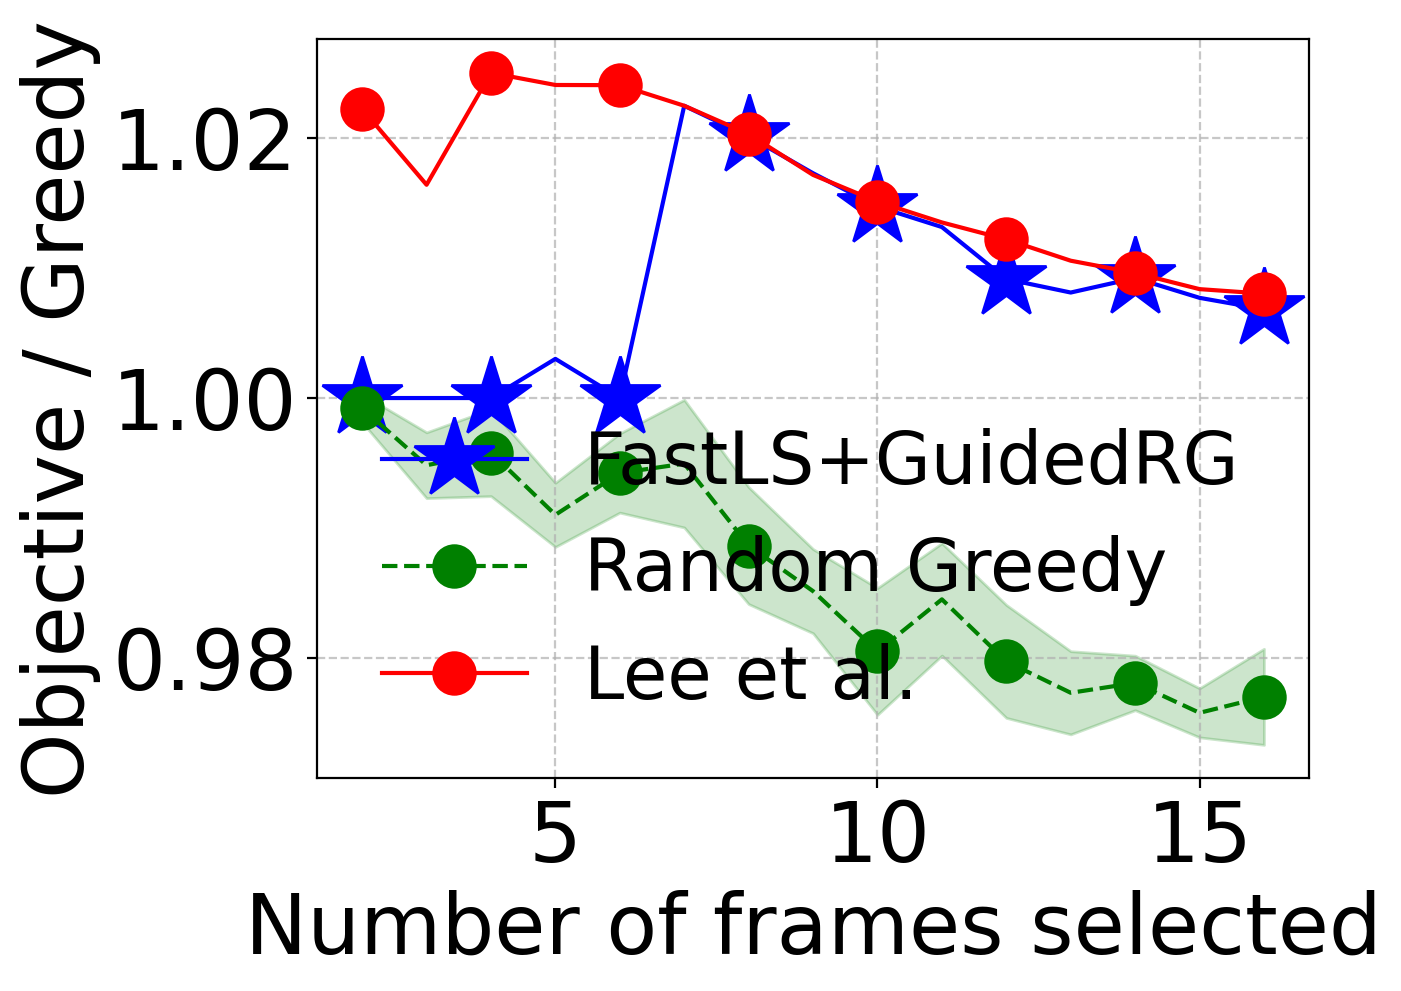

TypeError: LogLocator.set_params() got an unexpected keyword argument 'nbins'

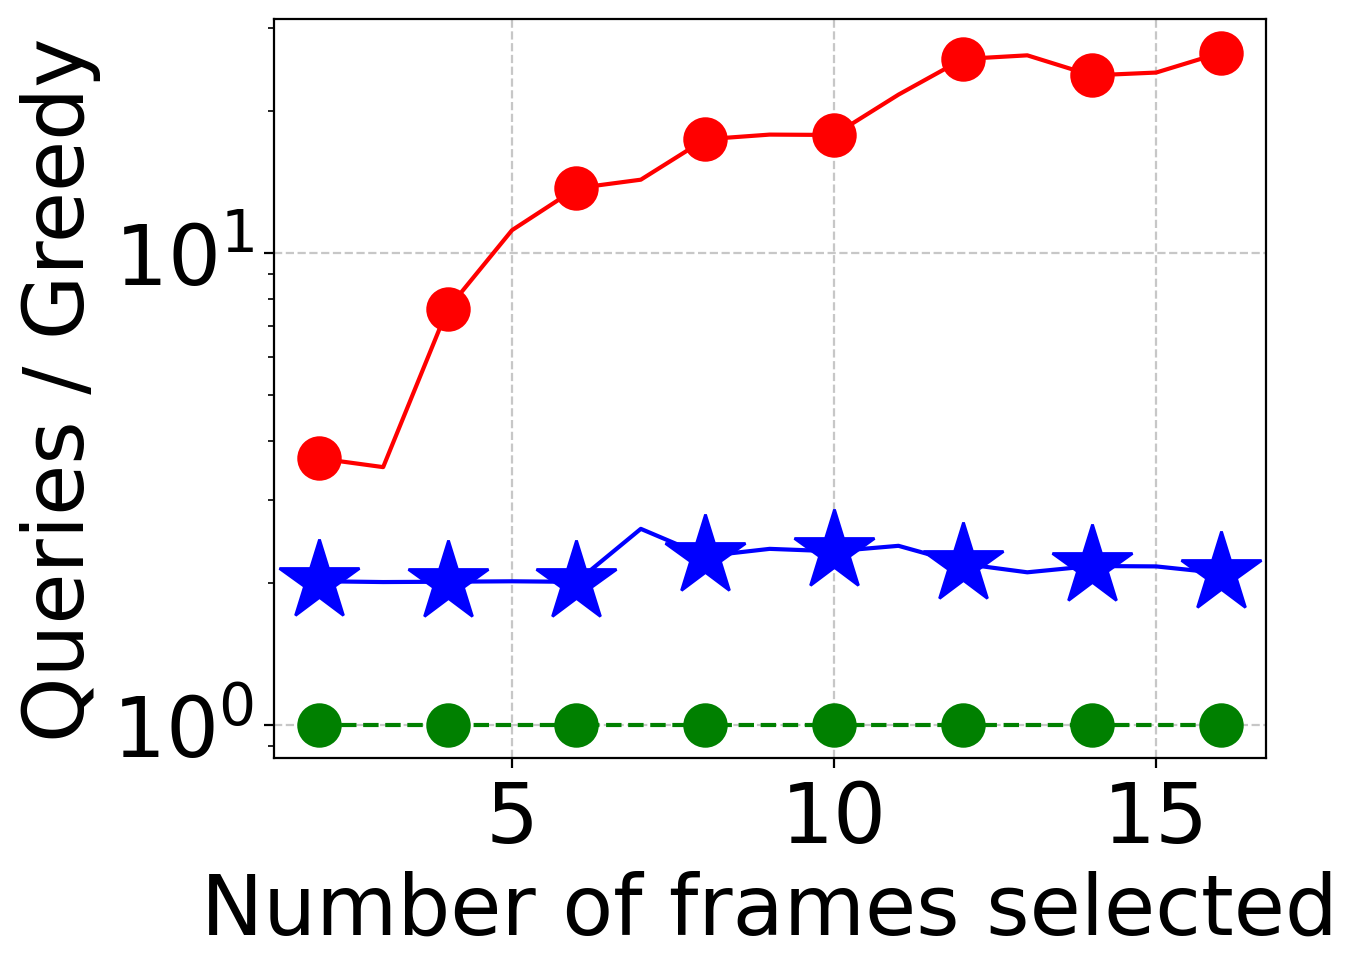

In [29]:
plt.figure(dpi=200)

markersize=30
markevery=2

x_label_font_size=y_label_font_size=x_ticks_font_size=y_ticks_font_size=30
legend_fontsize=26

plt.plot(pd_df['Size constraint'], pd_df['FLS_RAND_Greedy']/pd_df['Standard_Greedy'], 
         label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=markersize, markevery=markevery)
plt.plot(pd_df['Size constraint'], pd_df['Random_Greedy']/pd_df['Standard_Greedy'], 
         label='Random Greedy', marker='.', 
         linestyle='--', color='green',markersize=markersize, markevery=markevery)
plt.fill_between(pd_df['Size constraint'], 
                 (pd_df['Random_Greedy']/pd_df['Standard_Greedy']) - (pd_df['Random_Greedy_STD']/ pd_df['Standard_Greedy'] / 2),
                 (pd_df['Random_Greedy']/ pd_df['Standard_Greedy']) + (pd_df['Random_Greedy_STD']/ pd_df['Standard_Greedy'] / 2),
                 color='green', alpha=0.2)
plt.plot(pd_df['Size constraint'], pd_df['LEE_LS']/pd_df['Standard_Greedy'], 
         label='Lee et al.', 
         marker='.', linestyle='-', color='red',markersize=markersize, markevery=markevery)
# Add labels and title
plt.xlabel('Number of frames selected',fontsize=x_label_font_size)
plt.ylabel('Objective / Greedy',fontsize=y_label_font_size)
plt.xticks(fontsize=x_ticks_font_size)
plt.yticks(fontsize=y_ticks_font_size)

# Add a legend
# plt.legend(loc='lower left',fontsize="26", framealpha=0.0)
plt.legend(fontsize=legend_fontsize, framealpha=0.0)

# Customize the grid lines
plt.grid(True, linestyle='--', alpha=0.7)
plt.locator_params(nbins=4)
# Save the plot to a file (optional)
plt.savefig(f'ObjectiveVideoSummarization.pdf', dpi=300,bbox_inches='tight')

# Show the plot
plt.show()


plt.figure(dpi=200)
plt.plot(pd_df['Size constraint'], pd_df['FLS_RAND_Greedy_Query']/pd_df['Standard_Greedy_Query'], 
         label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=markersize, markevery=markevery)
plt.plot(pd_df['Size constraint'], pd_df['Random_Greedy_Query']/pd_df['Standard_Greedy_Query'], 
         label='Random Greedy', marker='.', 
         linestyle='--', color='green',markersize=markersize, markevery=markevery)
plt.plot(pd_df['Size constraint'], pd_df['LEE_LS_Query']/pd_df['Standard_Greedy_Query'], 
         label='Lee et al.', 
         marker='.', linestyle='-', color='red',markersize=markersize, markevery=markevery)

plt.xlabel('Number of frames selected',fontsize=x_label_font_size)
plt.ylabel('Queries / Greedy',fontsize=y_label_font_size)
plt.xticks(fontsize=x_ticks_font_size)
plt.yticks(fontsize=y_ticks_font_size)
# plt.legend(fontsize=16)

# Customize the grid lines
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')


plt.locator_params(nbins=4)
plt.savefig(f'QueriesVideoSummarization.pdf', dpi=300,bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
pd_df

Size constraint     LEE_LS  LEE_LS_Query  LEE_LS_STD  FLS_RAND_Greedy  \
0                 2   9.091384         741.0         0.0         8.893426   
1                 3  12.806549        1058.0         0.0        12.599648   
2                 4  16.549772        3031.0         0.0        16.145485   
3                 5  20.087396        5537.0         0.0        19.673713   
4                 6  23.584334        8110.0         0.0        23.029508   
5                 7  26.946512        9812.0         0.0        26.946512   
6                 8  30.268905       13584.0         0.0        30.263375   
7                 9  33.525052       15553.0         0.0        33.529298   
8                10  36.768315       17159.0         0.0        36.754489   
9                11  39.940214       22858.0         0.0        39.926247   
10               12  43.061820       29511.0         0.0        42.931867   
11               13  46.060694       32376.0         0.0        45.949001   
12               14  49.039262       31450.0         0.0        49.019909   
13               15  51.958433       33982.0         0.0        51.923914   
14               16  54.866628       39692.0         0.0        54.801278   

    FLS_RAND_Greedy_Query  FLS_RAND_Greedy_STD  Standard_Greedy  \
0                   407.0                  0.0         8.893426   
1                   604.0                  0.0        12.599648   
2                   802.0                  0.0        16.145485   
3                   999.0                  0.0        19.614580   
4                  1189.0                  0.0        23.029508   
5                  1787.0                  0.0        26.353422   
6                  1778.0                  0.0        29.665887   
7                  2062.0                  0.0        32.958807   
8                  2252.0                  0.0        36.220558   
9                  2531.0                  0.0        39.407353   
10                 2516.0                  0.0        42.542100   
11                 2601.0                  0.0        45.578731   
12                 2873.0                  0.0        48.571214   
13                 3056.0                  0.0        51.526343   
14                 3137.0                  0.0        54.429175   

    Standard_Greedy_Query  Standard_Greedy_Std  Random_Greedy  \
0                     202                    0       8.886411   
1                     301                    0      12.534449   
2                     399                    0      16.077602   
3                     496                    0      19.438195   
4                     592                    0      22.896505   
5                     687                    0      26.220338   
6                     781                    0      29.328851   
7                     874                    0      32.468681   
8                     966                    0      35.513890   
9                    1057                    0      38.796438   
10                   1147                    0      41.679386   
11                   1236                    0      44.544234   
12                   1324                    0      47.505703   
13                   1411                    0      50.277356   
14                   1497                    0      53.176917   

    Random_Greedy_Query  Random_Greedy_STD  
0                 202.0           0.019276  
1                 301.0           0.063857  
2                 399.0           0.108119  
3                 496.0           0.096926  
4                 592.0           0.140396  
5                 687.0           0.259162  
6                 781.0           0.267287  
7                 874.0           0.213624  
8                 966.0           0.353315  
9                1057.0           0.341150  
10               1147.0           0.370045  
11               1236.0           0.291856  
12               1324.0           0.203846  
13               1411.0    

In [16]:
# from google.colab import files

# # Assuming 'example.txt' is the name of the file you want to download
# files.download('video_df.pkl')


In [17]:
# plt.figure(dpi=200)
# plt.plot(pd_df['Size constraint'], pd_df['FLS_RAND_Greedy']/pd_df['Standard_Greedy'], label='FLS+Guided Random Greedy', marker='.', linestyle='-', color='blue')
# plt.plot(pd_df['Size constraint'], pd_df['Random_Greedy']/pd_df['Standard_Greedy'], label='Random Greedy', marker='.', linestyle='--', color='green')
# plt.plot(pd_df['Size constraint'], pd_df['LEE_LS']/pd_df['Standard_Greedy'], label='Approximate Local Search', marker='.', linestyle='--', color='red')
# # Add labels and title
# plt.xlabel('Number of frames selected')
# plt.ylabel('Objective Value over Standard Greedy')

# # Add a legend
# plt.legend()

# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)

# # Save the plot to a file (optional)
# plt.savefig(f'Objective value video summarization Error Rate {error_rate}.pdf', dpi=300)

# # Show the plot
# plt.show()

In [18]:
# plt.figure(dpi=200)
# plt.plot(pd_df['Size constraint'], pd_df['FLS_RAND_Greedy_Query']/pd_df['Standard_Greedy_Query'], label='FLS+Guided Random Greedy', marker='.', linestyle='-', color='blue')
# plt.plot(pd_df['Size constraint'], pd_df['Random_Greedy_Query']/pd_df['Standard_Greedy_Query'], label='Random Greedy', marker='.', linestyle='--', color='green')
# plt.plot(pd_df['Size constraint'], pd_df['LEE_LS_Query']/pd_df['Standard_Greedy_Query'], label='Lee et al.', marker='.', linestyle='--', color='red')

# plt.xlabel('Number of frames selected')
# plt.ylabel('Number of Queries over Standard Greedy')
# plt.legend()

# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)



# plt.savefig(f'Queries video summarization Error Rate {error_rate}.pdf', dpi=300)

# # Show the plot
# plt.show()

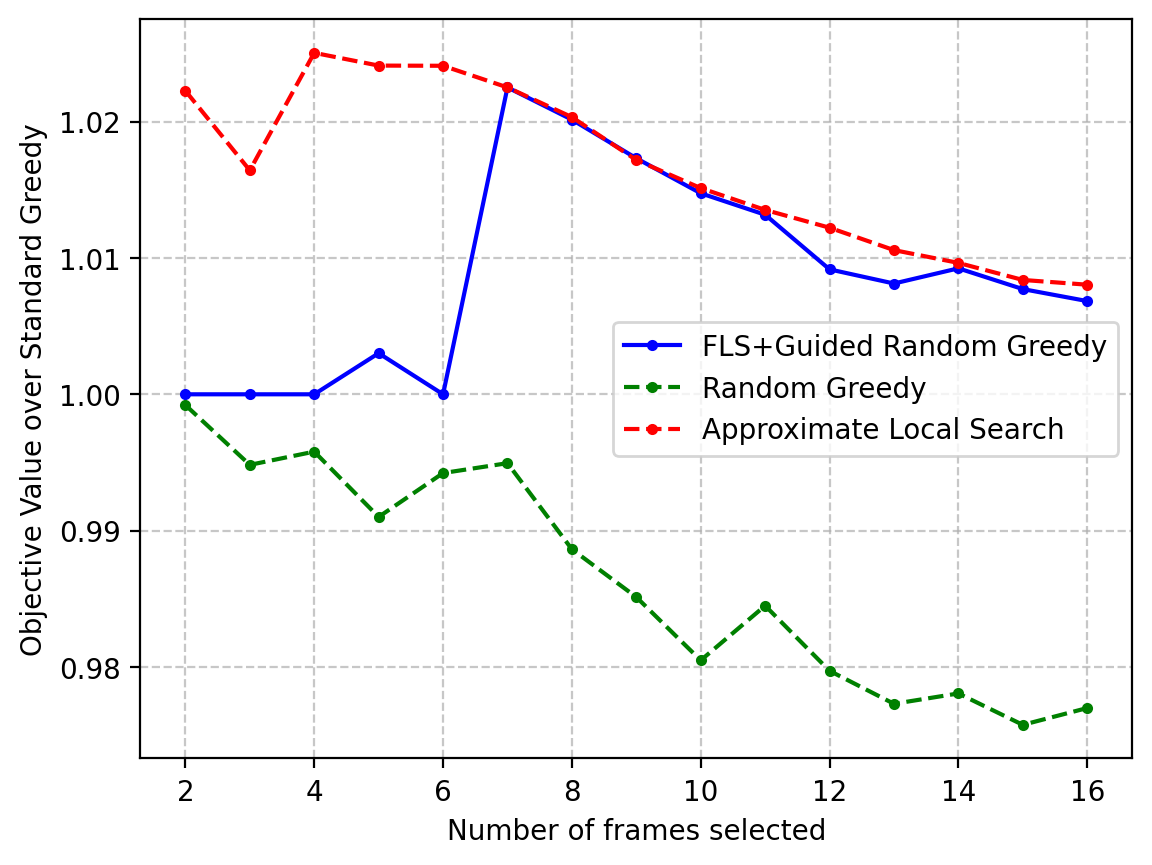

In [19]:
plt.figure(dpi=200)
plt.plot(pd_df['Size constraint'], pd_df['FLS_RAND_Greedy']/pd_df['Standard_Greedy'], label='FLS+Guided Random Greedy', marker='.', linestyle='-', color='blue')
plt.plot(pd_df['Size constraint'], pd_df['Random_Greedy']/pd_df['Standard_Greedy'], label='Random Greedy', marker='.', linestyle='--', color='green')
plt.plot(pd_df['Size constraint'], pd_df['LEE_LS']/pd_df['Standard_Greedy'], label='Approximate Local Search', marker='.', linestyle='--', color='red')
# Add labels and title
plt.xlabel('Number of frames selected')
plt.ylabel('Objective Value over Standard Greedy')

# Add a legend
plt.legend()

# Customize the grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Save the plot to a file (optional)
plt.savefig(f'Objective value video summarization Error Rate {error_rate}.pdf', dpi=300)

# Show the plot
plt.show()

In [20]:
greedy_solution=torch.tensor(sorted(list(sols[('greedy',8,0.01)])),dtype=torch.long)
fls_solution=torch.tensor(sorted(list(sols[('fls',8,0.01)])),dtype=torch.long)

In [21]:
def tensor_to_pil(title,tensor_images):

  img_list=[]
  print(f'Saving and showing figure for {title}')


  for tensor_image in tensor_images:

    tensor_image = tensor_image.byte()
    numpy_image = tensor_image.numpy()
    pil_image = Image.fromarray(numpy_image)
    img_list.append(pil_image)

  num_images = len(img_list)
  num_columns = 4
  num_rows = (num_images + num_columns - 1) // num_columns

  fig, axes = plt.subplots(num_rows, num_columns, figsize=(24, 3.5 * num_rows),gridspec_kw = {'wspace':0.09, 'hspace':0.1})  # Adjust figsize based on image size and layout


  for i, ax in enumerate(axes.flat):
      if i < num_images:
          img = img_list[i]
          ax.imshow(img,aspect='auto')
          ax.set_axis_off()



  plt.savefig(f'{title}.pdf', dpi=300, bbox_inches='tight')
  plt.show()





Saving and showing figure for Fast Local Search with Guided Random Greedy


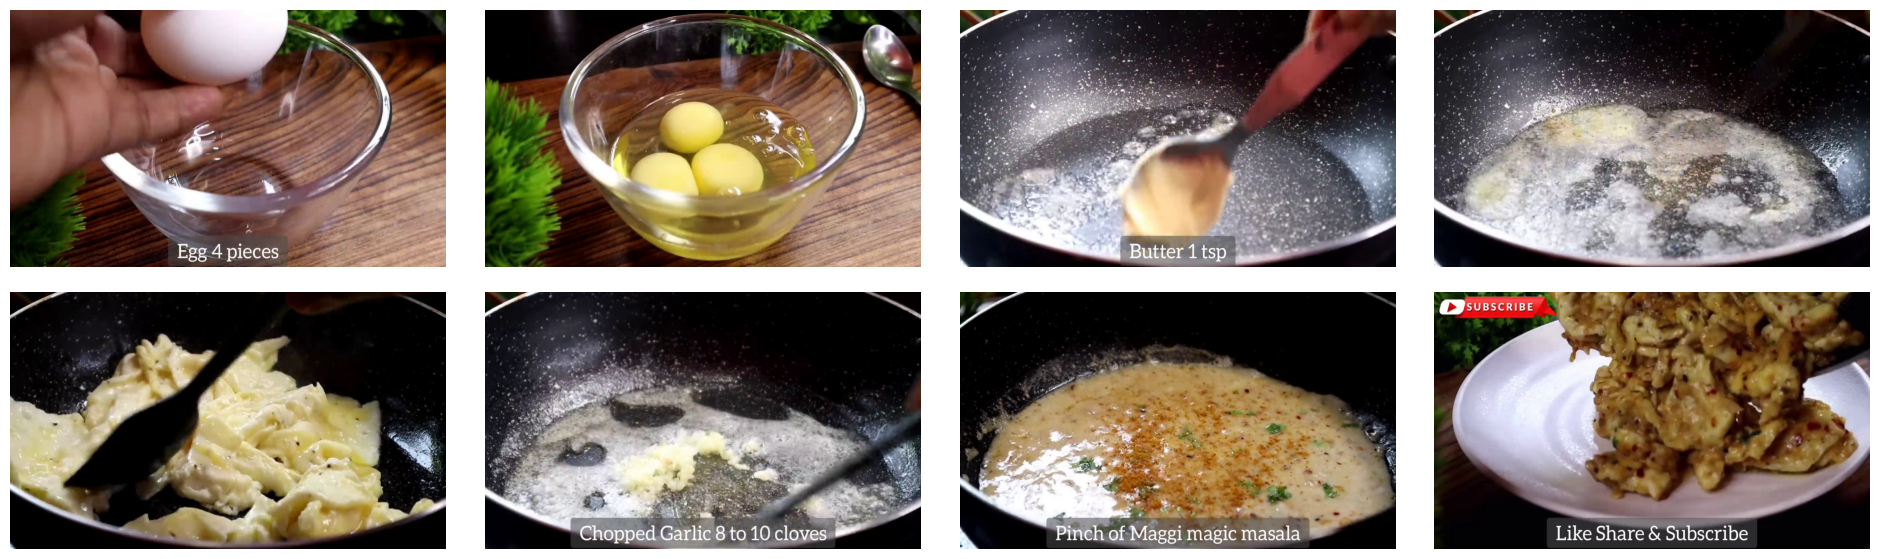

In [22]:
tensor_to_pil(title='Fast Local Search with Guided Random Greedy',tensor_images=frms[fls_solution])

Saving and showing figure for  Greedy


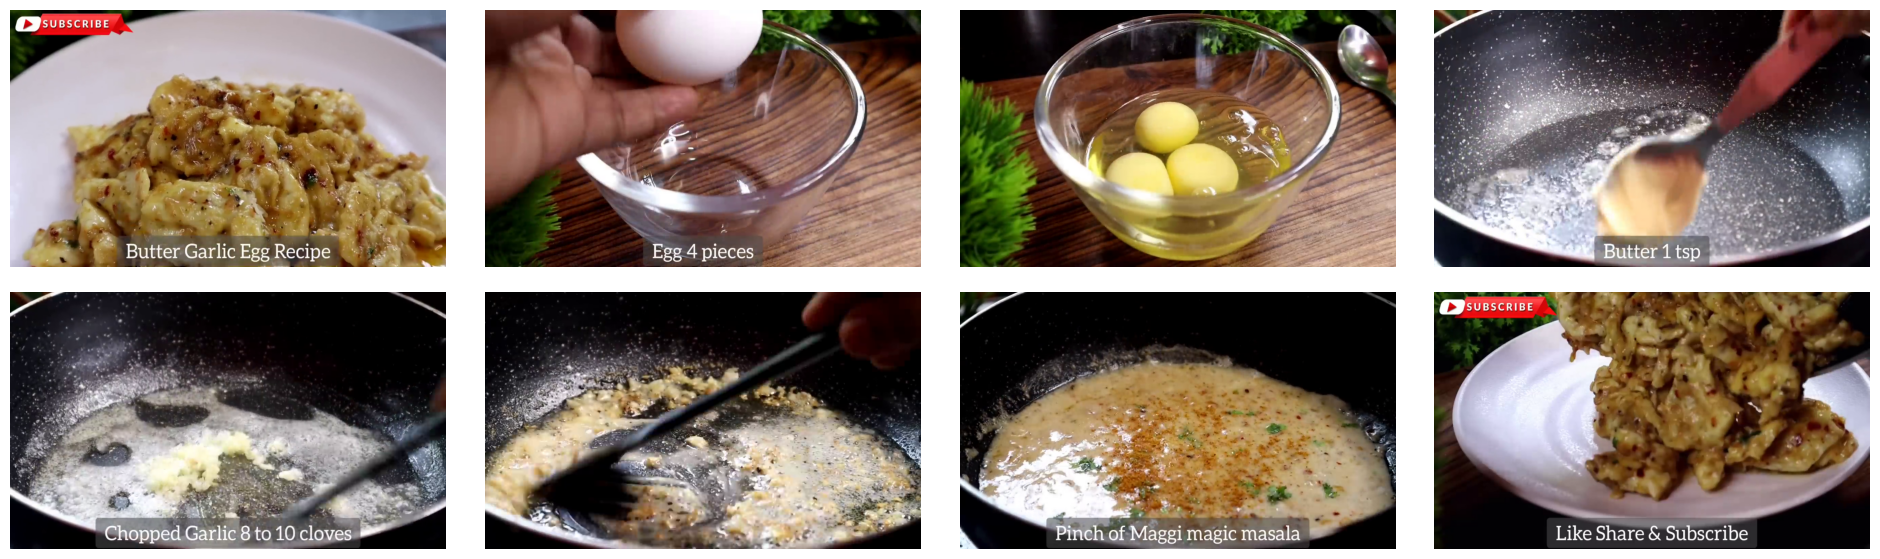

In [23]:
tensor_to_pil(title=' Greedy',tensor_images=frms[greedy_solution])

In [24]:
import os
def save_image(folder,images):

  if not os.path.exists(folder):
    os.mkdir(folder)

  print(folder)



  for i,tensor_image in enumerate(images):

    tensor_image = tensor_image.byte()
    numpy_image = tensor_image.numpy()
    pil_image = Image.fromarray(numpy_image)
    pil_image.save(os.path.join(folder,f"frame {str(i).zfill(2)}.png"))





In [25]:
save_image(folder='fast local search',images=frms[fls_solution])

fast local search


In [26]:
save_image(folder='greedy',images=frms[greedy_solution])

greedy
